<a href="https://colab.research.google.com/github/joshmurr/biodesign_biggan/blob/master/BigGAN_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-pretrained-biggan

In [ ]:
!pip install nltk libsixel-python

  Created wheel for libsixel-python: filename=libsixel_python-0.5.0-cp36-none-any.whl size=12276 sha256=5f2685e89b063b9a348acb79df1b1ce821f231e0376549a859184d24da23f010
  Stored in directory: /root/.cache/pip/wheels/83/ba/62/a3c568b79bf35a7a79d44cf0ceb11212006484019a4413d5d1
Successfully built libsixel-python


In [ ]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)


import nltk
nltk.download('wordnet')

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=3)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

save_as_images(output)

In [ ]:
def show_image(_tensor):
  img = _tensor.permute(1, 2,0).detach().numpy()
  img = np.clip(((img + 1) / 2.0) * 256, 0, 255)
  plt.imshow(np.asarray(np.uint8(img), dtype=np.uint8))

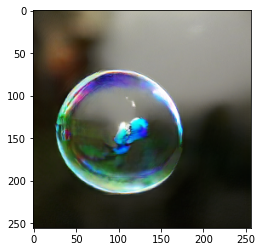

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

show_image(output[0])

In [ ]:
def gen(noise_vector, class_vector, truncation):
  embed = model.embeddings(class_vector)
  cond_vector = torch.cat((noise_vector, embed), dim=1)

  # Mapping
  z = gen.gen_z(cond_vector)
  # Treat vector as an image
  z = z.view(-1, 4, 4, 16 * gen.config.channel_width)
  # Not shown: conversion to account for using TensorFlow weights instead of PyTorch weights

  # Iterate over the layers, assigning the output of the previous layer to "z"
  for i, layer in enumerate(gen.layers):
    if isinstance(layer, GenBlock):
      # Residual block
      z = layer(z, cond_vector, truncation)
    else:
      # This is the self-attention layer
      z = layer(z)

  # Batch norm layer
  z = gen.bn(z, truncation)
  z = gen.relu(z)
  # Final convolution
  z = gen.conv_to_rgb(z)
  # For some reason TensorFlow weights output 8 channels instead of 3
  z = z[:, :3, ...]
  # Final activation
  z = gen.tanh(z)

  return z

In [ ]:
truncation = 0.9
class_vector = one_hot_from_names(['soap bubble'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=3)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

output = output.to('cpu')

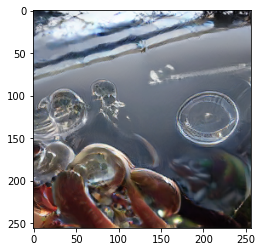

In [ ]:
show_image(output[2])

In [ ]:
noise_vector.shape

torch.Size([3, 128])

In [ ]:
def slerp(A, B, num_interps):  # see https://en.wikipedia.org/wiki/Slerp
  alphas = np.linspace(-1.5, 2.5, num_interps) # each unit step tends to be a 90 degree rotation in high-D space, so this is ~360 degrees
  omega = np.zeros((A.shape[0],1))
  for i in range(A.shape[0]):
      tmp = np.dot(A[i],B[i])/(np.linalg.norm(A[i])*np.linalg.norm(B[i]))
      omega[i] = np.arccos(np.clip(tmp,0.0,1.0))+1e-9
  return np.array([(np.sin((1-a)*omega)/np.sin(omega))*A + (np.sin(a*omega)/np.sin(omega))*B for a in alphas])

def slerp_and_shape(A, B, num_interps):
  interps = slerp(A, B, num_interps)
  return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                 .reshape(num_interps, *interps.shape[2:]))

In [ ]:
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble'], batch_size=1)
noise_vectorA = truncated_noise_sample(truncation=truncation, batch_size=1)
noise_vectorB = truncated_noise_sample(truncation=truncation, batch_size=1)


L = slerp(noise_vectorA, noise_vectorB, 60)

In [ ]:
row = []
class_vector = one_hot_from_names(['soap bubble'], batch_size=1)
class_vector = torch.from_numpy(class_vector)
class_vector = class_vector.to('cuda')

for z in L:
  noise_vector = torch.from_numpy(z)
  noise_vector = noise_vector.to('cuda').float()

  model.to('cuda')
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  output = output.to('cpu')
  row.append(output)



In [ ]:
import torchvision

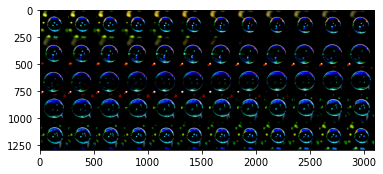

In [ ]:
grid = torchvision.utils.make_grid(torch.cat(row), nrow=12)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
import cv2
from google.colab import files
def make_video(video_name, imgs, codec='MJPG'):
  _, _, height, width = imgs.shape
  video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*codec), fps=24, frameSize=(width,height))
  for iter in range(0,imgs.shape[0]):
    frame = get_image(imgs[iter], permute=[2,1,0])
    video.write(frame)
  cv2.destroyAllWindows()
  video.release()
  files.download(video_name)

In [ ]:
images = torch.cat(row)
make_video('bubbles.mov', images)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

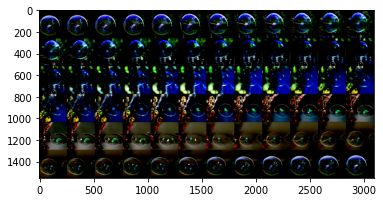

In [ ]:
truncation = 1.0
class_vector = one_hot_from_names(['soap bubble'], batch_size=1)
noise_vectorA = truncated_noise_sample(truncation=truncation, batch_size=1)
noise_vectorB = truncated_noise_sample(truncation=truncation, batch_size=1)


L = slerp(noise_vectorA, noise_vectorB, 24*3)

row = []
class_vector = one_hot_from_names(['soap bubble'], batch_size=1)
class_vector = torch.from_numpy(class_vector)
class_vector = class_vector.to('cuda')

for z in L:
  noise_vector = torch.from_numpy(z)
  noise_vector = noise_vector.to('cuda').float()

  model.to('cuda')
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  output = output.to('cpu')
  row.append(output)

grid = torchvision.utils.make_grid(torch.cat(row), nrow=12)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
make_video('bubbles.mov', torch.cat(row, axis=0))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

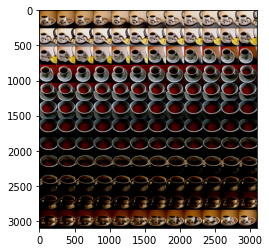

In [ ]:
truncation = 1.0
noise_vectorA = truncated_noise_sample(truncation=truncation, batch_size=1)
noise_vectorB = truncated_noise_sample(truncation=truncation, batch_size=1)

L = slerp(noise_vectorA, noise_vectorB, 24*6)

row = []
class_vector = one_hot_from_names(['coffee'], batch_size=1)
class_vector = torch.from_numpy(class_vector)
class_vector = class_vector.to('cuda')

for z in L:
  noise_vector = torch.from_numpy(z)
  noise_vector = noise_vector.to('cuda').float()

  model.to('cuda')
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  output = output.to('cpu')
  row.append(output)

grid = torchvision.utils.make_grid(torch.cat(row), nrow=12)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
make_video('coffee.mov', torch.cat(row, axis=0))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_image(_tensor, permute=[0, 1, 2]):
  img = _tensor.permute(1, 2, 0).detach().numpy()
  img = img[:, :, permute]
  img = np.clip(((img + 1) / 2.0) * 256, 0, 255)
  return np.asarray(np.uint8(img), dtype=np.uint8)

(256, 256, 3)


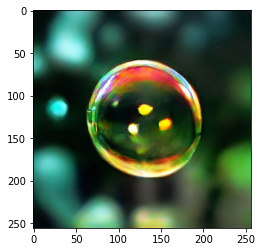

In [ ]:
frame = get_image(images[0])
print(frame.shape)
plt.imshow(frame)

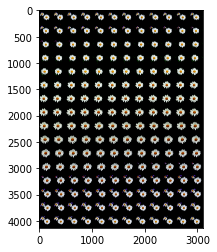

In [ ]:
truncation = 0.6
noise_vectorA = truncated_noise_sample(truncation=truncation, batch_size=1)
noise_vectorB = truncated_noise_sample(truncation=truncation, batch_size=1)

L = slerp(noise_vectorA, noise_vectorB, 24*8)

row = []
class_vector = one_hot_from_names(['daisy'], batch_size=1)
class_vector = torch.from_numpy(class_vector)
class_vector = class_vector.to('cuda')

for z in L:
  noise_vector = torch.from_numpy(z)
  noise_vector = noise_vector.to('cuda').float()

  model.to('cuda')
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  output = output.to('cpu')
  row.append(output)

grid = torchvision.utils.make_grid(torch.cat(row), nrow=12)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
make_video('daisy_long.mp4', torch.cat(row, axis=0), codec='DIVX')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>